In [1]:
#| default_exp fid

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
from scipy import linalg

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from diy_stable_diffusion.datasets import *
from diy_stable_diffusion.conv import *
from diy_stable_diffusion.learner import *
from diy_stable_diffusion.activations import *
from diy_stable_diffusion.init import *
from diy_stable_diffusion.sgd import *
from diy_stable_diffusion.resnet import *
from diy_stable_diffusion.augment import *
from diy_stable_diffusion.accel import *

In [3]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

In [4]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 512

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2))*2-1 for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
xb,yb = next(iter(dls.train))

In [6]:
cbs =  [DeviceCB(), MixedPrecision()]
model=torch.load('../../p2/nbs/models/data_aug2.pkl')
learn = Learner(model, dls, F.cross_entropy, cbs=cbs, opt_func=None)

In [7]:
def append_outp(hook, mod, inp, outp):
    if not hasattr(hook, 'outp'):
        hook.outp = []
    
    if type(outp) is torch.Tensor:
        hook.outp.append(to_cpu(outp))

In [8]:
'''
Capture a different index than Jeremy's notebook does because this
saved model of mine has a bunch of extra layers his doesn't, I added
a bunch of dropout layers.
'''
hcb = HooksCallback(append_outp, mods=[learn.model[6]], on_valid=True)

learn.fit(1, do_train=False, do_validate=True, cbs=[hcb])

feats = hcb.hooks[0].outp[0].float()[:64]
feats.shape

torch.Size([64, 512])

In [9]:
del(learn.model[8])
del(learn.model[7])

In [10]:
feats,y=learn.capture_preds()
feats = feats.float()
feats.shape,y

(torch.Size([10000, 512]), tensor([9., 2., 1.,  ..., 8., 1., 5.]))

# Calculating FID

Copy over backward pass (sample) code from Jeremy's notebook just to 
get to the point of calculating FID, since I'm handwriting the sample functions
in other notebooks and FID is the important part of this lesson

In [11]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.0 - beta
alphabar = alpha.cumprod(dim=0)
sigma=beta.sqrt()

In [12]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample


In [13]:
smodel=torch.load('models/2024-01-12-fashion_ddpm3_25_jfshfioa.pkl').cuda()

In [14]:
smodel_jeremy=torch.load('../../p2/nbs/models/fashion_ddpm_mp.pkl').cuda()

In [15]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * model((x_t, t_batch)))/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_0_hat.cpu())
    return preds

In [16]:
samples=sample(smodel, (256, 1, 32, 32), alpha, alphabar, sigma, n_steps)

In [18]:
samples = samples[-1] * 2

In [19]:
# From my model
samples.mean(),samples.min(), samples.max(), samples.median()

(tensor(-0.61), tensor(-1.06), tensor(1.39), tensor(-1.00))

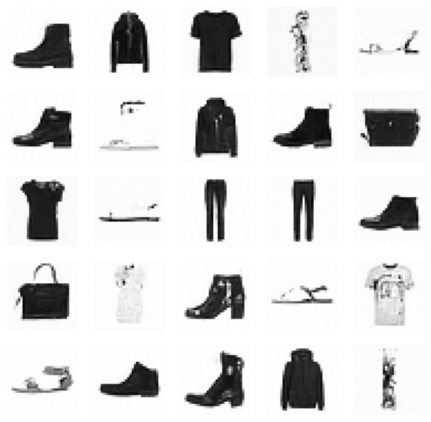

In [22]:
# 2024-01-12-fashion_ddpm3_25_jfshfioa.pkl
show_images(samples[:25], imsize=1.5)

In [21]:
clearn = TrainLearner(model, DataLoaders([], [(samples, yb)]), loss_func=fc.noop, cbs=[DeviceCB()], opt_func=None)
feats2, y2 = clearn.capture_preds()

In [23]:
feats2.shape, y2.shape

(torch.Size([256, 512]), torch.Size([512]))

In [24]:
'''
yb shouldn't be above, it's only there to provide a filler tensor of "y values" and even the size doesn't seem to matter
'''
clearn2 = TrainLearner(model, DataLoaders([], [(samples, torch.tensor([]))]), loss_func=fc.noop, cbs=[DeviceCB()], opt_func=None)

feats2, _ = clearn2.capture_preds()
feats2.shape

torch.Size([256, 512])

In [25]:
#|export
def _sqrtm_newton_schulz(mat, num_iters=100):
    mat_norm = mat.norm()
    mat = mat.double()
    Y = mat/mat_norm
    n = len(mat)
    I = torch.eye(n).to(mat)
    Z = torch.eye(n).to(mat)
    
    for i in range(num_iters):
        T = (3*I - Z@Y) / 2
        Y = Y@T
        Z = T@Z
        res = Y*mat_norm.sqrt()
        
        if ((mat - (res @ res)).norm() / mat_norm).abs() <=1e-6:
            break
    
    return res

In [26]:
#|export
def _calc_stats(feats):
    feats = feats.squeeze()
    return feats.mean(0), feats.T.cov()

def _calc_fid(means1, covs1, means2, covs2):
    csr = tensor(linalg.sqrtm(covs1@covs2, 256).real)
    '''
    return (
        ((means1 - means2)**2).sum() +
        covs1.trace() + covs2.trace() - 2*csr.trace()
    ).item()
    '''
    return (((means1-means2)**2).sum() + covs1.trace() + covs2.trace() - 2*csr.trace()).item()

In [27]:
means1,covs1 = _calc_stats(feats)
means2, covs2 = _calc_stats(feats2)

In [28]:
covs1.min(),covs1.max()

(tensor(-2.45), tensor(7.59))

In [29]:
covsbycovs = covs1 @ covs2
covsbycovs.min(),covsbycovs.max()

(tensor(-436.39), tensor(719.03))

In [31]:
msqrt = linalg.sqrtm(covsbycovs, 256)
msqrt.shape

(512, 512)

In [32]:
torch.save(covsbycovs, 'models/covsbycovs18.pkl')

In [ ]:
[(t.mean(),t.var()) for t in [means1, covs1, means2, covs2]]

In [ ]:
# still much worse but not in the 8000s anymore
_calc_fid(means1, covs1, means2, covs2)

In [ ]:
stats_me = _calc_stats(feats2)
stats_dataset, stats_jeremy = _calc_stats(feats), _calc_stats(feats2_jeremy)
# Jeremy's FID, my FID
_calc_fid(*stats_dataset, *stats_jeremy),_calc_fid(*stats_dataset, *stats_me)

# KID

In [ ]:
#|export
def _squared_mmd(x, y):
    def kernel(a, b):
        return ((a@b.transpose(-2, -1) / a.shape[-1]) + 1)**3
    
    m, n = x.shape[-2], y.shape[-2]
    kxx, kyy, kxy = kernel(x,x), kernel(y, y), kernel(x, y)
    kxx_sum = kxx.sum([-1, -2]) - kxx.diagonal(0, -1, -2).sum(-1)
    kyy_sum = kyy.sum([-1, -2]) - kyy.diagonal(0, -1, -2).sum(-1)
    kxy_sum = kxy.sum([-1, -2])
    
    return (
        kxx_sum / (m * (m-1)) +
        kyy_sum / (n * (n-1)) -
        kxy_sum*2 / (m * n)
    )

In [ ]:
#|export
def _calc_kid(x, y, maxs=50):
    xs, ys = x.shape[0], y.shape[0]
    n= max(math.ceil(min(xs/maxs, ys/maxs)), 4)
    mmd = 0.0
    for i in range(n):
        cur_x = x[round(i*xs / n) : round((i+1)*xs / n)]
        cur_y = y[round(i*ys / n) : round((i+1)*ys / n)]
        mmd += _squared_mmd(cur_x, cur_y)
    return (mmd/n).item()

In [ ]:
# my KID, Jeremy's KID
_calc_kid(feats, feats2), _calc_kid(feats, feats2_jeremy)

In [ ]:
#|export
class ImageEval:
    def __init__(self, model, dls, cbs):
        self.learn=TrainLearner(model, dls, loss_func=fc.noop, cbs=cbs, opt_func=None)
        self.feats = self.learn.capture_preds()[0].float().cpu().squeeze()
        self.stats = _calc_stats(self.feats)
    
    def get_feats(self, samples):
        self.learn.dls = DataLoaders([], [(samples, torch.zeros((0,)))])
        return self.learn.capture_preds()[0].float().cpu().squeeze()
    
    def fid(self, samples):
        feats = self.get_feats(samples)
        return _calc_fid(*self.stats, *_calc_stats(feats))
    
    def kid(self, samples):
        feats = self.get_feats(samples)
        return _calc_kid(self.feats, feats)

In [ ]:
ie = ImageEval(model, dls, [DeviceCB()])

In [ ]:
ie.fid(samples)
#ie.fid(samples_jeremy_ddpm)

In [ ]:
ie.feats.shape,ie.get_feats(samples).shape

In [ ]:
ie.kid(samples), ie.kid(samples_jeremy_ddpm)

In [ ]:
import nbdev; nbdev.nbdev_export()